In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

In [18]:
!nvidia-smi
# to know which version of GPU we have installed on the machine

Wed Oct 27 23:04:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.49       Driver Version: 457.49       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   30C    P8     4W /  N/A |    315MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading the data

In [19]:
train_df = pd.read_csv('./data/train.csv')
print("\nThe train dataset is {}".format(train_df.shape))
train_df.head()


The train dataset is (4459, 4993)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [20]:
test_df = pd.read_csv('./data/test.csv')
print("\nThe test dataset is {}".format(test_df.shape))
test_df.head()


The test dataset is (49342, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visualization

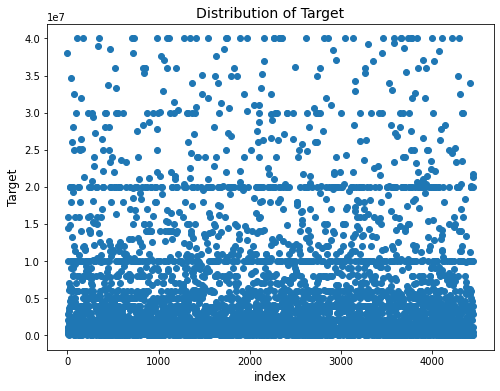

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), (train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Distribution of Target', fontsize=14)
plt.show()

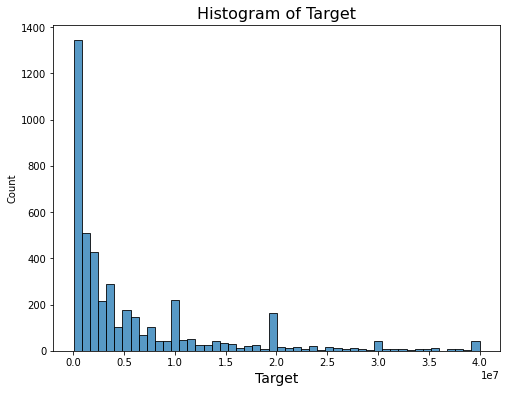

In [22]:
plt.figure(figsize=(8,6))
sns.histplot(train_df["target"].values,bins=50,kde=False)
plt.xlabel("Target",fontsize=14)
plt.title("Histogram of Target",fontsize=16)
plt.show()

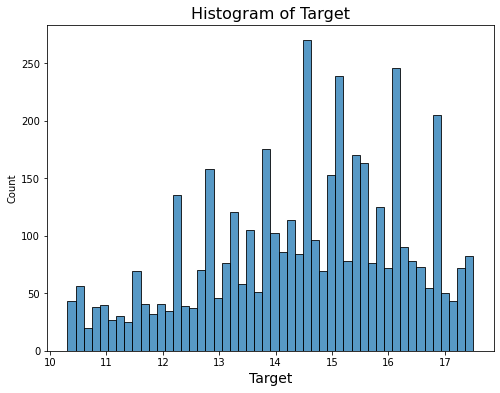

In [23]:
plt.figure(figsize=(8,6))
sns.histplot(np.log1p(train_df["target"]).values,bins=50,kde=False)
plt.xlabel("Target",fontsize=14)
plt.title("Histogram of Target",fontsize=16)
plt.show()

In [24]:
# If the standard deviation of any column is constant, that means the columns has a constant value. 
# We will drop these columns.
const_columns_to_remove = []
for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0:
            const_columns_to_remove.append(col)

# Now remove that array of const columns from the data
train_df.drop(const_columns_to_remove, axis=1, inplace=True)
test_df.drop(const_columns_to_remove, axis=1, inplace=True)

# Print to see the reduction of columns
print('train_df rows and columns after removing constant columns: ', train_df.shape)

print('Following `{}` Constant Column\n are removed'.format(len(const_columns_to_remove)))
print(const_columns_to_remove)

train_df rows and columns after removing constant columns:  (4459, 4737)
Following `256` Constant Column
 are removed
['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e

In [25]:
# So we onit thos columns that have unique values less than 3.

def drop_sparse_from_train_test(train, test):
    column_list_to_drop_data_from = [x for x in train.columns if not x in ['ID','target']]
    for f in column_list_to_drop_data_from:
        if len(np.unique(train[f]))<3:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

train_df, test_df = drop_sparse_from_train_test(train_df, test_df)
print('Train rows and columns after removing duplicate columns: ', train_df.shape)

Train rows and columns after removing duplicate columns:  (4459, 4492)


In [26]:
X_train = train_df.drop(['ID', 'target'], axis=1)

y_train = np.log1p(train_df['target'].values)

X_test_original = test_df.drop('ID', axis=1)

X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [27]:
print("X_train_split.shape: ",X_train_split.shape)
print("X_validation.shape: ",X_validation.shape)
print("y_train_split.shape: ",y_train_split.shape)
print("y_validation.shape: ",y_validation.shape)

X_train_split.shape:  (3567, 4490)
X_validation.shape:  (892, 4490)
y_train_split.shape:  (3567,)
y_validation.shape:  (892,)


# Model training
## we will be training lighgbm, catboost, and random forest and ensemble them

In [28]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.001,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    # Given its a regression case, I am using the RMSE as the metric.

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, lg_train, 5000,
                      valid_sets=[lg_train, lg_validation],
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )

    pred_test_light_gbm = np.expm1(model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration ))

    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm

In [29]:
# Training and output of LightGBM Model
predictions_test_y_light_gbm, model_lgbm, evals_result = light_gbm_model_run(X_train_split, y_train_split, X_validation, y_validation, X_test_original)
print('Output of LightGBM Model training..')

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.66447	valid_1's rmse: 1.63998
[300]	training's rmse: 1.57647	valid_1's rmse: 1.59273
[450]	training's rmse: 1.49838	valid_1's rmse: 1.55444
[600]	training's rmse: 1.42899	valid_1's rmse: 1.5229
[750]	training's rmse: 1.36605	valid_1's rmse: 1.49779
[900]	training's rmse: 1.30903	valid_1's rmse: 1.47722
[1050]	training's rmse: 1.25715	valid_1's rmse: 1.46109
[1200]	training's rmse: 1.20994	valid_1's rmse: 1.44797
[1350]	training's rmse: 1.16675	valid_1's rmse: 1.43745
[1500]	training's rmse: 1.12708	valid_1's rmse: 1.42923
[1650]	training's rmse: 1.09046	valid_1's rmse: 1.42251
[1800]	training's rmse: 1.05679	valid_1's rmse: 1.41778
[1950]	training's rmse: 1.02548	valid_1's rmse: 1.41419
[2100]	training's rmse: 0.995928	valid_1's rmse: 1.4113
[2250]	training's rmse: 0.96824	valid_1's rmse: 1.40915
[2400]	training's rmse: 0.941909	valid_1's rmse

In [30]:
# Feature Importance
gain_light_gbm = model_lgbm.feature_importance('gain')
feature_imp_light_gbm = pd.DataFrame({'feature': model_lgbm.feature_name(),
                                      'split': model_lgbm.feature_importance('split'),
                                      'gain': 100 * gain_light_gbm / gain_light_gbm.sum()
}).sort_values('gain', ascending=False)
print(feature_imp_light_gbm[:10])

        feature  split      gain
3923  f190486d6   6790  6.931083
2252  58e2e02e6   6115  4.920505
3293  eeb9cd3aa   5559  4.045366
2478  9fd594eec   4122  3.176494
3819  15ace8c9f   5251  3.011257
8     20aa07010   3674  1.897522
3394  58232a6fb   3506  1.457728
789   6eef030c1   3736  1.278441
1375  b43a7cfd5   4265  1.250970
2548  fb0f5dbfe   4565  1.124296


In [31]:
# Now Catboost model training

model_catboost = CatBoostRegressor(iterations=500,
                                   task_type="CPU",
                                   learning_rate=0.01,
                                   depth=10,
                                   eval_metric='RMSE',
                                   random_seed = 42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20
                                   )

model_catboost.fit(X_train_split, y_train_split,
                   eval_set=(X_validation, y_validation),
                   use_best_model=True,
                   verbose=50
                   )

predictions_test_y_catboost = np.expm1(model_catboost.predict(X_test_original))

0:	learn: 1.7617179	test: 1.6946171	best: 1.6946171 (0)	total: 1.3s	remaining: 10m 51s
50:	learn: 1.6745580	test: 1.6327048	best: 1.6327048 (50)	total: 1m 10s	remaining: 10m 24s
100:	learn: 1.6117394	test: 1.5932799	best: 1.5932799 (100)	total: 2m 20s	remaining: 9m 15s
150:	learn: 1.5630664	test: 1.5638821	best: 1.5638821 (150)	total: 3m 30s	remaining: 8m 5s
200:	learn: 1.5199584	test: 1.5402982	best: 1.5402982 (200)	total: 4m 39s	remaining: 6m 56s
250:	learn: 1.4859854	test: 1.5229879	best: 1.5229879 (250)	total: 5m 48s	remaining: 5m 45s
300:	learn: 1.4585405	test: 1.5106145	best: 1.5106145 (300)	total: 6m 58s	remaining: 4m 36s
350:	learn: 1.4351936	test: 1.5022715	best: 1.5022715 (350)	total: 8m 5s	remaining: 3m 26s
400:	learn: 1.4131594	test: 1.4935093	best: 1.4935093 (400)	total: 9m 12s	remaining: 2m 16s
450:	learn: 1.3941466	test: 1.4866797	best: 1.4866797 (450)	total: 10m 19s	remaining: 1m 7s
499:	learn: 1.3777439	test: 1.4815115	best: 1.4815115 (499)	total: 11m 25s	remaining: 0u

In [32]:
# random forest modeling

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_split,y_train_split)

RandomForestRegressor(random_state=42)

In [33]:
# performance of each model on validation set (subset of train set)

print(model_lgbm.__class__.__name__,mean_squared_error(y_validation,model_lgbm.predict(X_validation)))
print(model_catboost.__class__.__name__,mean_squared_error(y_validation,model_catboost.predict(X_validation)))
print(model_rf.__class__.__name__,mean_squared_error(y_validation,model_rf.predict(X_validation)))

Booster 1.9701035787250827
CatBoostRegressor 2.1948763250803367
RandomForestRegressor 2.030658769053715


# Ensemble Model

In [36]:
# defining ensemble

# randomforest
model_rf = RandomForestRegressor()

# catboost
model_catboost = CatBoostRegressor(random_state=42, verbose=False, iterations=500,
                                   task_type="CPU",
                                   learning_rate=0.01,
                                   depth=10,
                                   eval_metric='RMSE',
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20)

# lightgbm
model_lgbm = LGBMRegressor(objective = "regression",
        metric = "rmse",
        num_leaves = 100,
        learning_rate = 0.001,
        bagging_fraction = 0.6,
        feature_fraction = 0.6,
        bagging_frequency = 6,
        verbosity = -1,
        seed= 42)


# defining ensemble
ensemble_regressor = VotingRegressor(
    [('rf', model_rf), ('cb', model_catboost), ('lgbm', model_lgbm)])

ensemble_regressor.fit(X_train_split,y_train_split)

print(ensemble_regressor.__class__.__name__,mean_squared_error(y_validation,ensemble_regressor.predict(X_validation)))



[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
VotingRegressor 2.1871918735484037


In [37]:
prediction_ensemble = np.expm1(ensemble_regressor.predict(X_test_original))

In [38]:
submission_final = pd.read_csv('./data/sample_submission.csv')

submission_final['target'] = prediction_ensemble
submission_final.to_csv('./data/submission_final.csv', index=False)